In [66]:
#from ../src/map_extractor.py import *
from pylab import contour
import matplotlib.pyplot as plt
from PIL import ImageFilter, Image, ImageDraw
from datetime import date, timedelta
import numpy as np
from PIL import Image
import cv2
from skimage import measure
import os

%matplotlib inline


# Extract contours


In [67]:
def dates_between(start, stop):
    while start <= stop:
        yield start
        start += timedelta(days=1)
        
def hydrological_year(at_date):
    if at_date.month > 6:
        return at_date.year + 1
    else:
        return at_date.year
    

In [68]:
# colors definitions RGB alpha
black = np.array([0, 0, 0])
white = np.array([255, 255, 255])


light_blue = np.array([213, 252, 252])
light_medium_blue = np.array([168, 217, 241])
medium_blue = np.array([121, 161, 229])
dark_medium_blue = np.array([68, 89, 215]) #68 88 215
dark_blue = np.array([47, 36, 162])
purple = np.array([91, 32, 196])

blue1 = np.array([53, 65, 212])
blue2 = np.array([96, 128, 222])
blue3 = np.array([83, 111, 192])
blue4 = np.array([48, 59, 195])
blue5 = np.array([176, 224, 243])
blue6 = np.array([171, 217, 236])

shades_blue = [light_blue, light_medium_blue, medium_blue, dark_medium_blue, dark_blue, purple]

shades_grey = [np.array([c,c,c]) for c in range(255)]

image_shades = [light_blue, light_medium_blue, medium_blue, dark_medium_blue, dark_blue, purple, white]

green = np.array([204, 255, 102])


raw_red = np.array([255, 0, 0])
raw_green = np.array([0, 255, 0])
raw_blue = np.array([0, 0, 255])
raw_pink = np.array([255, 0, 255])
raw_pink = np.array([255, 0, 255])
raw_cyan = np.array([0, 255, 255])
raw_yellow = np.array([255, 255, 0])

In [69]:
def keep_colors(img, colors, replace_with=white):
    """return a new image with only the `colors` selected, other pixel are `replace_with`"""
    keep = np.zeros(img.shape[:2], dtype=bool)
    for c in colors:
        keep = keep | (c == img).all(axis=-1)
    new_img = img.copy()
    new_img[~keep] = replace_with
    return new_img

#TODO: add to .py if works correctly
def remove_colors(img, colors, replace_with=white):
    """return a new image without the `colors` selected which will be replaced by `replace_with`"""
    keep = np.zeros(img.shape[:2], dtype=bool)
    for c in colors:
        keep = keep | (c == img).all(axis=-1)
    new_img = img.copy()
    new_img[keep] = replace_with
    return new_img

def numpify(o):
    if not isinstance(o, np.ndarray):
        o = np.array(o)
    return o

# remove contours areas that have more than 30% of white
WHITE_RATIO_THRESHOLD = .3

def color_contours(img, color):
    img = numpify(img)
    color = numpify(color)
    mask = (img == color[:3]).all(axis=-1)
    monocholor = img.copy()
    monocholor[~mask] = 255
    contours = measure.find_contours(mask, 0.5)
    
    # heuristic filter for contours
    filter_contours = []
    for c in contours:
        region = Image.new("L", [img.shape[1], img.shape[0]], 0)
        ImageDraw.Draw(region).polygon(list(map(lambda t: (t[1],t[0]), c)), fill=1)
        region = np.array(region).astype(bool)
        white_ratio = (monocholor == 255).all(axis=-1)[region].mean()
        if white_ratio <= WHITE_RATIO_THRESHOLD:
            filter_contours.append(c)
    return filter_contours

In [70]:
#path = '../data/slf/2003/hn1/de/gif/20030105_hn1_de_c.gif'# avec textures deg
#path = '../data/slf/2003/hn1/de/gif/20030206_hn1_de_c.gif' # avec textures deg
#path = '../data/slf/2003/hsr2000/de/gif/20021218_hsr2000_de_c.gif' # couleurs normales
path = '../data/slf/2010/hstop/en/gif/20100103_hstop_en_c.gif' # hstop super pixelise

img = Image.open(path)
img = img.convert('RGB')
img_arr = np.array(img)

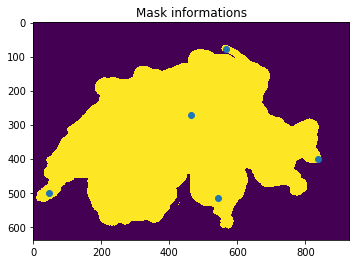

In [71]:
# load mask of this size

leman_west = (6.148131, 46.206042)
quatre_canton_north = (8.435177, 47.082150)
majeur_east = (8.856851, 46.151857)
east_end = (10.472221, 46.544303)
constance_nw = (9.035247, 47.812716)

landmarks_colors = {
    leman_west: raw_red,
    quatre_canton_north: raw_green,
    majeur_east: raw_blue,
    constance_nw: raw_pink,
    east_end: raw_yellow,
}

def coord_color(img, color):
    return np.array(list(zip(*(img == color).all(-1).nonzero())))

def open_mask(height, width):
    masks_path = '../map-masks/'
    mask_name = '{}x{}.gif'.format(height, width)
    mask_path = os.path.join(masks_path, mask_name)
    mask = Image.open(mask_path)
    mask = mask.convert('RGB')
    mask = np.array(mask)
    
    landmarks_pix = {
        geo_point: (width, height)
        for geo_point, color in landmarks_colors.items()
        for height, width in coord_color(mask, color)
    }
    
    binary_mask = (mask != 255).any(-1)  # different of white
    return binary_mask, landmarks_pix

binary_mask, landmarks_pix = open_mask(*img_arr.shape[:2])

#binary mask has 1 row of pixels unnecessary
binary_mask = np.delete(binary_mask, (639), axis=0)

fix, ax = plt.subplots()
ax.imshow(binary_mask);
widths, heights = list(zip(*landmarks_pix.values()))
ax.scatter(widths, heights);
ax.set_title('Mask informations');

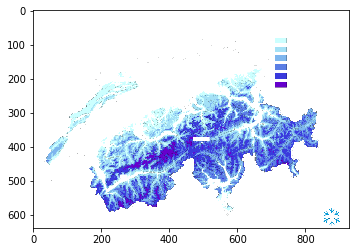

In [73]:
#remove greys
im = img_arr.copy()
plt.imshow(remove_colors(im, shades_grey));

Color matching: as the image cotains a lot of noise we will map the image colors to the existing ones in the shades_blue array.

In [74]:
im.shape

(639, 929, 3)

TODO: apply remove colors to the following

In [75]:
#create set of colors existing in image
import pandas as pd
im_df = pd.DataFrame([img_arr[i,j,:] for i,j in np.ndindex(img_arr.shape[0],img_arr.shape[1])])
im_df = im_df.drop_duplicates()

image_colors = im_df.as_matrix()

In [76]:
from scipy.spatial import distance
colors = np.zeros(image_colors.shape)
dist = distance.cdist(image_colors, image_shades, 'sqeuclidean')

for j in range(dist.shape[0]):
    distances = dist[j,:]
    colors[j, :] = image_shades[distances.argmin()]

In [77]:
colors.shape

(256, 3)

In [79]:
color_map = pd.DataFrame(
    {'source': image_colors.tolist(),
     'target': colors.tolist()
    })

In [80]:
color_map

,source,target
0,"[128, 128, 128]","[121.0, 161.0, 229.0]"
1,"[0, 0, 0]","[47.0, 36.0, 162.0]"
2,"[192, 192, 192]","[168.0, 217.0, 241.0]"
3,"[255, 255, 255]","[255.0, 255.0, 255.0]"
4,"[43, 43, 43]","[47.0, 36.0, 162.0]"
5,"[63, 63, 63]","[47.0, 36.0, 162.0]"
6,"[239, 239, 239]","[255.0, 255.0, 255.0]"
7,"[208, 208, 208]","[168.0, 217.0, 241.0]"
8,"[94, 94, 94]","[47.0, 36.0, 162.0]"
9,"[20, 20, 20]","[47.0, 36.0, 162.0]"


In [81]:
def replace_color(img, color_map=color_map):
    new_img = img.copy()
    for _, (source, target) in color_map.iterrows():
        new_img[(img == source).all(axis=-1)] = target
    return new_img

In [82]:
img_arr.shape
img_arr = remove_colors(img_arr, colors=shades_grey)
img_arr = replace_color(img_arr)

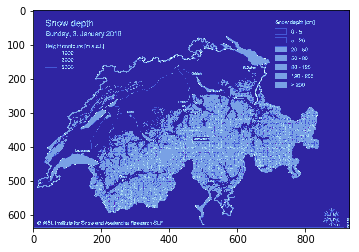

In [57]:
plt.imshow(img_arr);

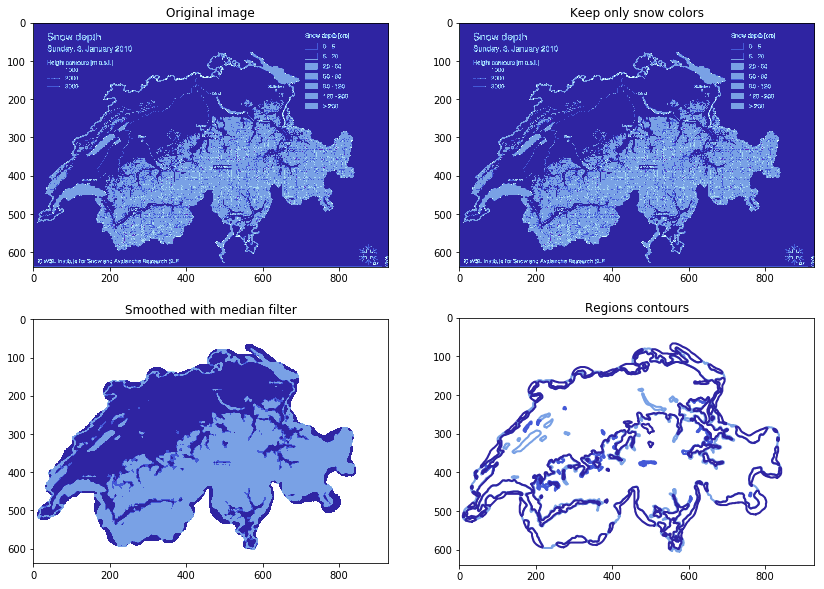

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))

# original image
axes[0][0].imshow(img_arr);
axes[0][0].set_title('Original image');

#img_arr = im 

# keep useful colors
regions_only = keep_colors(img_arr, shades_blue)
axes[0][1].imshow(regions_only);
axes[0][1].set_title('Keep only snow colors');

# clip the binary mask to remove color key
regions_only[~binary_mask] = 255
regions_only = Image.fromarray(regions_only).convert('RGB')
smoothed = regions_only.filter(ImageFilter.MedianFilter(7))
axes[1][0].imshow(smoothed);
axes[1][0].set_title('Smoothed with median filter');

# extract contours
axes[1][1].set_xlim([0, img_arr.shape[1]])
axes[1][1].set_ylim([0, img_arr.shape[0]])
axes[1][1].invert_yaxis()
axes[1][1].set_title('Regions contours')

for color in shades_blue:
    contours = color_contours(smoothed, color)
    for contour in contours:
        axes[1][1].plot(contour[:, 1], contour[:, 0], linewidth=2, c=[x / 255 for x in color])
